## Implementar

## Implementar el descenso de gradiente basado en momento

In [2]:
import numpy as np

In [3]:
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1.0 - np.tanh(x) ** 2

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

def initialize_weights_glorot(n_in, n_out):
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, (n_out, n_in))

def initialize_weights_he(n_in, n_out):
    return np.random.randn(n_out, n_in) * np.sqrt(2 / n_in)

In [10]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activations=None, dropout_rates=None, momentum=True):
        """
        Initialize the neural network with support for different activation functions and dropout.
        
        Parameters:
        -----------
        layer_sizes : list
            List containing the size of each layer
        activations : list, optional
            List containing the activation function for each layer (default: tanh for all)
        dropout_rates : list, optional
            List containing dropout rate for each layer (default: no dropout)
        momentum : bool, optional
            True if gradient descent with momentum will be used during training, False otherwise
        """
        self.num_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.momentum = momentum
        
        # Initialize activation functions
        if activations is None:
            self.activations = ['tanh'] * (self.num_layers - 1)
        else:
            self.activations = activations
        
        # Map activation functions to their implementations
        self.activation_funcs = {
            'tanh': tanh,
            'relu': relu,
            'sigmoid': sigmoid
        }
        
        self.activation_primes = {
            'tanh': tanh_prime,
            'relu': relu_prime,
            'sigmoid': sigmoid_prime
        }
        
        # Initialize dropout rates (0 means no dropout)
        if dropout_rates is None:
            self.dropout_rates = [0] * (self.num_layers - 1)
        else:
            self.dropout_rates = dropout_rates
            
        # Initialize weights with appropriate initializers based on activation function
        self.weights = []
        for i in range(len(layer_sizes) - 1):
            if self.activations[i] == 'relu':
                # He initialization for ReLU
                self.weights.append(initialize_weights_he(layer_sizes[i], layer_sizes[i+1]))
            else:
                # Glorot/Xavier initialization for tanh/sigmoid
                self.weights.append(initialize_weights_glorot(layer_sizes[i], layer_sizes[i+1]))
        
        # Initialize biases, velocities, and batch normalization parameters
        self.biases = [np.zeros((y, 1)) for y in layer_sizes[1:]]
        self.velocity_b = [np.zeros(b.shape) for b in self.biases]
        self.velocity_w = [np.zeros(w.shape) for w in self.weights]
        
        # For L2 regularization
        self.lambd = 0.0  # regularization parameter, 0 means no regularization
        
        # Track if we're in training mode (for dropout)
        self.training = True
    
    def toggle_training(self, training=True):
        """Toggle between training and evaluation mode (affects dropout)"""
        self.training = training
    
    def apply_dropout(self, layer_output, dropout_rate):
        """Apply dropout to layer output during training"""
        if not self.training or dropout_rate == 0:
            return layer_output, None
        
        # Generate dropout mask
        keep_prob = 1 - dropout_rate
        mask = np.random.binomial(1, keep_prob, size=layer_output.shape) / keep_prob
        
        # Apply mask
        return layer_output * mask, mask
    
    def feedforward(self, a, return_intermediates=False):
        """
        Perform forward propagation through the network.
        
        Parameters:
        -----------
        a : ndarray
            Input to the network
        return_intermediates : bool, optional
            If True, return intermediate values for backpropagation
            
        Returns:
        --------
        If return_intermediates is False, returns only the final output.
        If return_intermediates is True, returns (activations, zs, dropout_masks)
        """
        activations = [a]
        zs = []
        dropout_masks = []
        
        for i, (b, w) in enumerate(zip(self.biases, self.weights)):
            z = np.dot(w, activations[-1]) + b
            zs.append(z)
            
            # Apply activation function
            activation_func = self.activation_funcs[self.activations[i]]
            a = activation_func(z)
            
            # Apply dropout (except at the output layer)
            if i < len(self.weights) - 1 and self.dropout_rates[i] > 0:
                a, mask = self.apply_dropout(a, self.dropout_rates[i])
                dropout_masks.append(mask)
            else:
                dropout_masks.append(None)
                
            activations.append(a)
        
        if return_intermediates:
            return activations, zs, dropout_masks
        else:
            return activations[-1]
    
    def backpropagation(self, x, y):
        """
        Perform backpropagation to compute gradients.
        
        Parameters:
        -----------
        x : ndarray
            Input to the network
        y : ndarray
            Target output
            
        Returns:
        --------
        tuple (grad_b, grad_w) containing gradients
        """
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
        # Forward pass
        activations, zs, dropout_masks = self.feedforward(x, return_intermediates=True)
        
        # Backward pass
        # Compute the error at the output layer
        delta = self.cost_derivative(activations[-1], y)
        
        # Apply the derivative of the activation function
        output_activation = self.activations[-1]
        delta = delta * self.activation_primes[output_activation](zs[-1])
        
        # Set the gradients for the output layer
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].T)
        
        # Add L2 regularization to the weights gradient (not biases)
        if self.lambd > 0:
            grad_w[-1] += (self.lambd / len(x)) * self.weights[-1]
        
        # Backpropagate the error
        for l in range(2, len(self.biases) + 1):
            # Get the activation derivative for this layer
            activation_func = self.activations[-l]
            delta = np.dot(self.weights[-l+1].T, delta)
            
            # Apply dropout mask from the forward pass
            if dropout_masks[-l] is not None:
                delta = delta * dropout_masks[-l]
            
            # Apply activation derivative
            delta = delta * self.activation_primes[activation_func](zs[-l])
            
            # Set gradients
            grad_b[-l] = delta
            grad_w[-l] = np.dot(delta, activations[-l-1].T)
            
            # Add L2 regularization
            if self.lambd > 0:
                grad_w[-l] += (self.lambd / len(x)) * self.weights[-l]
        
        return (grad_b, grad_w)
    
    def momentum_gradient_descent(self, mini_batch, eta, mu=0.9):
        """
        Update network parameters using gradient descent with momentum.
        
        Parameters:
        -----------
        mini_batch : list
            List of (x, y) tuples for training
        eta : float
            Learning rate
        mu : float, optional
            Momentum coefficient (default: 0.9)
        """
        batch_size = len(mini_batch)
        grad_b_sum = [np.zeros(b.shape) for b in self.biases]
        grad_w_sum = [np.zeros(w.shape) for w in self.weights]
        
        # Compute gradients for each sample in the mini-batch
        for x, y in mini_batch:
            grad_b, grad_w = self.backpropagation(x, y)
            
            # Accumulate gradients
            grad_b_sum = [gb_sum + gb for gb_sum, gb in zip(grad_b_sum, grad_b)]
            grad_w_sum = [gw_sum + gw for gw_sum, gw in zip(grad_w_sum, grad_w)]
        
        # Compute average gradients
        grad_b_avg = [gb / batch_size for gb in grad_b_sum]
        grad_w_avg = [gw / batch_size for gw in grad_w_sum]
        
        # Update weights and biases using momentum
        self.velocity_b = [mu * vb - eta * gb for vb, gb in zip(self.velocity_b, grad_b_avg)]
        self.velocity_w = [mu * vw - eta * gw for vw, gw in zip(self.velocity_w, grad_w_avg)]
        
        self.biases = [b + vb for b, vb in zip(self.biases, self.velocity_b)]
        self.weights = [w + vw for w, vw in zip(self.weights, self.velocity_w)]

    def standard_gradient_descent(self, mini_batch, eta):
        """
        Update network parameters using standard gradient descent.
        
        Parameters:
        -----------
        mini_batch : list
            List of (x, y) tuples for training
        eta : float
            Learning rate
        """
        batch_size = len(mini_batch)
        grad_b_sum = [np.zeros(b.shape) for b in self.biases]
        grad_w_sum = [np.zeros(w.shape) for w in self.weights]
        
        # Compute gradients for each sample in the mini-batch
        for x, y in mini_batch:
            grad_b, grad_w = self.backpropagation(x, y)
            
            # Accumulate gradients
            grad_b_sum = [gb_sum + gb for gb_sum, gb in zip(grad_b_sum, grad_b)]
            grad_w_sum = [gw_sum + gw for gw_sum, gw in zip(grad_w_sum, grad_w)]
        
        # Compute average gradients
        grad_b_avg = [gb / batch_size for gb in grad_b_sum]
        grad_w_avg = [gw / batch_size for gw in grad_w_sum]
        
        # Update weights and biases
        self.biases = [b - eta * gb for b, gb in zip(self.biases, grad_b_avg)]
        self.weights = [w - eta * gw for w, gw in zip(self.weights, grad_w_avg)]
    
    def cost_derivative(self, output_activations, y):
        """Derivative of the cost function (MSE)"""
        return output_activations - y
    
    def update_learning_rate(self, epoch, initial_lr, schedule_type="step_decay", decay=0.1, drop_every=1000):
        """
        Update learning rate based on schedule.
        
        Parameters:
        -----------
        epoch : int
            Current epoch number
        initial_lr : float
            Initial learning rate
        schedule_type : str, optional
            Type of learning rate schedule
        decay : float, optional
            Decay factor
        drop_every : int, optional
            Number of epochs between drops for step decay
            
        Returns:
        --------
        float : Updated learning rate
        """
        if schedule_type == "step_decay":
            return initial_lr * (decay ** np.floor(epoch / drop_every))
        elif schedule_type == "exp_decay":
            return initial_lr * np.exp(-decay * epoch)
        elif schedule_type == "inv_scaling":
            return initial_lr / (1 + decay * epoch)
        elif schedule_type == "cosine":
            # Cosine annealing
            max_epochs = 1000  # Default max epochs
            return initial_lr * (1 + np.cos(np.pi * epoch / max_epochs)) / 2
        else:
            return initial_lr
    
    def train(self, training_data, epochs, mini_batch_size, learning_rate, 
            decay=0.1, schedule_type="step_decay", validation_data=None,
            early_stopping_patience=None, verbose=True):
        """
        Train the neural network with progress tracking.
        
        Parameters:
        -----------
        training_data : list
            List of (x, y) tuples for training
        epochs : int
            Number of epochs to train
        mini_batch_size : int
            Size of mini-batches
        learning_rate : float
            Initial learning rate
        decay : float, optional
            Learning rate decay factor
        schedule_type : str, optional
            Type of learning rate schedule
        validation_data : list, optional
            List of (x, y) tuples for validation
        early_stopping_patience : int, optional
            Number of epochs to wait for improvement before stopping
        verbose : bool, optional
            Whether to print progress
            
        Returns:
        --------
        dict : Training history containing loss and validation metrics
        """
        try:
            from tqdm.auto import tqdm
            use_tqdm = True
        except ImportError:
            print("tqdm not installed. Install with 'pip install tqdm' for progress bars.")
            use_tqdm = False
        
        n = len(training_data)
        loss_history = []
        val_loss_history = [] if validation_data else None
        
        # For early stopping
        best_val_loss = float('inf')
        patience_counter = 0
        best_weights = None
        best_biases = None
        
        # Enable dropout during training
        self.toggle_training(True)
        
        # Create epoch iterator with tqdm if available
        epoch_iter = tqdm(range(epochs), desc="Training", unit="epoch") if use_tqdm else range(epochs)
        
        for j in epoch_iter:
            # Shuffle training data
            np.random.shuffle(training_data)
            
            # Create mini-batches
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            # Create mini-batch iterator with tqdm if available and verbose
            if use_tqdm and verbose:
                batch_iter = tqdm(mini_batches, desc=f"Epoch {j+1}/{epochs}", 
                                leave=False, unit="batch")
            else:
                batch_iter = mini_batches
            
            # Train on mini-batches
            for mini_batch in batch_iter:
                if self.momentum:
                    self.momentum_gradient_descent(mini_batch, learning_rate)
                else:
                    self.standard_gradient_descent(mini_batch, learning_rate)
            
            # Update learning rate
            new_lr = self.update_learning_rate(j, learning_rate, schedule_type, decay)
            
            # Calculate training loss
            self.toggle_training(False)  # Disable dropout for evaluation
            current_loss = np.mean(
                [np.mean((self.feedforward(x) - y) ** 2) for x, y in training_data]
            )
            loss_history.append(current_loss)
            
            # Calculate validation loss if validation data provided
            current_val_loss = None
            if validation_data:
                current_val_loss = np.mean(
                    [np.mean((self.feedforward(x) - y) ** 2) for x, y in validation_data]
                )
                val_loss_history.append(current_val_loss)
                
                # Early stopping check
                if early_stopping_patience:
                    if current_val_loss < best_val_loss:
                        best_val_loss = current_val_loss
                        patience_counter = 0
                        # Save best model weights
                        best_weights = [w.copy() for w in self.weights]
                        best_biases = [b.copy() for b in self.biases]
                    else:
                        patience_counter += 1
                        
                    if patience_counter >= early_stopping_patience:
                        if use_tqdm:
                            epoch_iter.set_postfix({
                                "early_stopping": True,
                                "best_val_loss": f"{best_val_loss:.6f}"
                            })
                        elif verbose:
                            print(f"Early stopping at epoch {j+1}")
                        break
            
            # Re-enable dropout for next training epoch
            self.toggle_training(True)
            
            # Update progress bar with metrics
            metrics = {
                "loss": f"{current_loss:.6f}",
                "lr": f"{new_lr:.6f}"
            }
            if current_val_loss is not None:
                metrics["val_loss"] = f"{current_val_loss:.6f}"
            
            if use_tqdm:
                epoch_iter.set_postfix(metrics)
            elif verbose and j % 10 == 0:
                val_str = f", Val Loss: {current_val_loss:.6f}" if current_val_loss is not None else ""
                print(f"Epoch {j+1}/{epochs}, Loss: {current_loss:.6f}{val_str}, LR: {new_lr:.6f}")
            
            # Update learning rate for next epoch
            learning_rate = new_lr
        
        # Restore best model if early stopping was used and best weights were saved
        if early_stopping_patience and best_weights is not None and best_biases is not None:
            self.weights = best_weights
            self.biases = best_biases
            if verbose:
                print(f"Restored best model with validation loss: {best_val_loss:.6f}")
        
        # Return results
        self.toggle_training(False)  # Ensure dropout is disabled after training
        return {
            "loss": loss_history,
            "val_loss": val_loss_history
        }


## Análisis y comparación

Training neural network...
tqdm not installed. Install with 'pip install tqdm' for progress bars.
Epoch 1/200, Loss: 0.033247, Val Loss: 0.035195, LR: 0.010000
Epoch 11/200, Loss: 0.007013, Val Loss: 0.007166, LR: 0.007596
Epoch 21/200, Loss: 0.006765, Val Loss: 0.006776, LR: 0.003499
Epoch 31/200, Loss: 0.006513, Val Loss: 0.006556, LR: 0.000978
Epoch 41/200, Loss: 0.006460, Val Loss: 0.006532, LR: 0.000166
Epoch 51/200, Loss: 0.006451, Val Loss: 0.006512, LR: 0.000017
Epoch 61/200, Loss: 0.006450, Val Loss: 0.006510, LR: 0.000001
Early stopping at epoch 62
Restored best model with validation loss: 0.006509
Training completed in 2.35 seconds


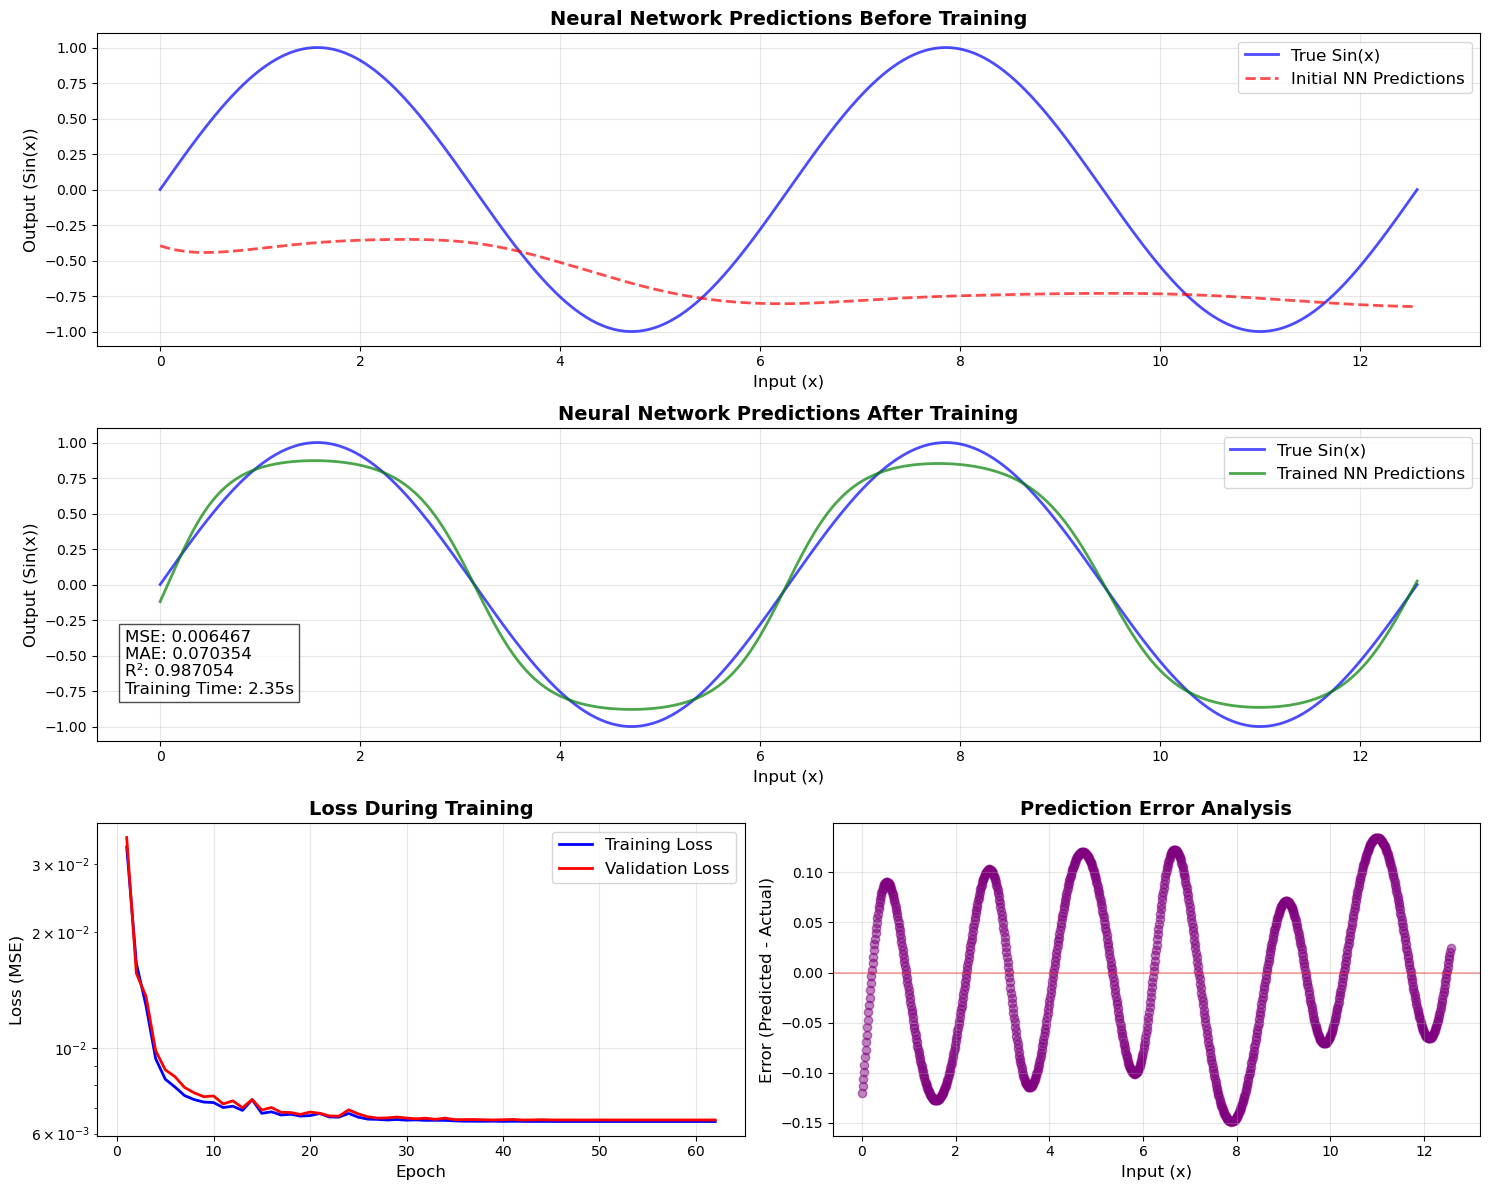

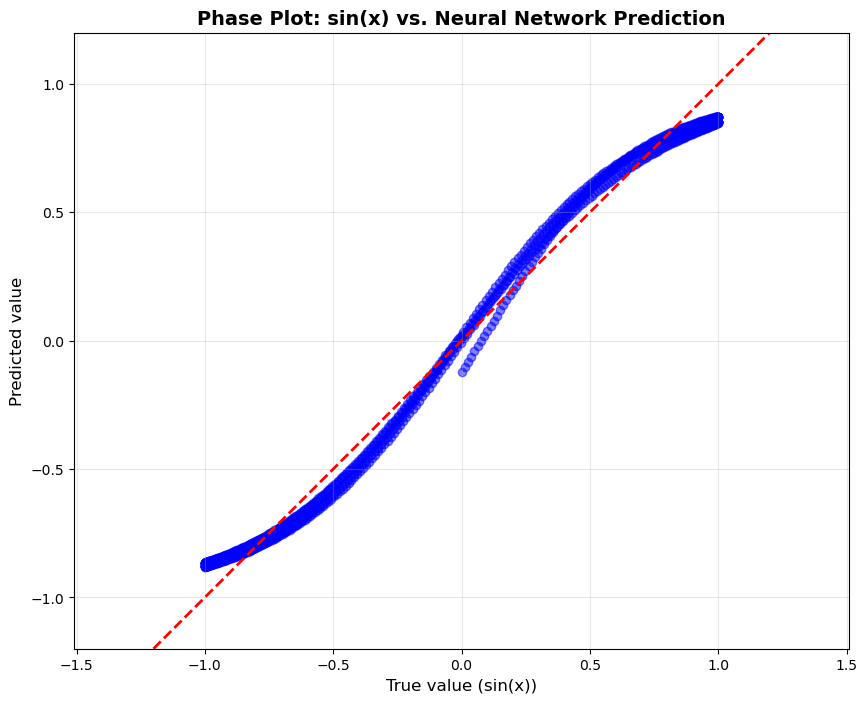

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
import time
import warnings

# Suppress tqdm warning
warnings.filterwarnings("ignore", category=UserWarning)

# Generate data with more range for better testing
x = np.linspace(0, 4 * np.pi, 1000)  # Expanded range to test generalization
y = np.sin(x)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Prepare data in the format needed by the neural network
training_data = [
    (np.array([i]).reshape(1, 1), np.array([j]).reshape(1, 1)) 
    for i, j in zip(x_train, y_train)
]
validation_data = [
    (np.array([i]).reshape(1, 1), np.array([j]).reshape(1, 1)) 
    for i, j in zip(x_val, y_val)
]

# Feature engineering: Add sin and cos of the input as features
# This helps the network learn periodic functions much faster
training_data_enhanced = [
    (np.array([[x[0][0], np.sin(x[0][0]), np.cos(x[0][0])]]).T, y) 
    for x, y in training_data
]
validation_data_enhanced = [
    (np.array([[x[0][0], np.sin(x[0][0]), np.cos(x[0][0])]]).T, y) 
    for x, y in validation_data
]

# Optimized network architecture for sine wave approximation
# with momentum
nn = NeuralNetwork(
    layer_sizes=[3, 32, 16, 1],  # Smaller network with engineered features
    activations=['tanh', 'tanh', 'tanh'],  # Tanh is ideal for sine waves
    dropout_rates=[0.0, 0.0, 0]  # No dropout needed with proper features
)

# Minimal L2 regularization
nn.lambd = 0.0

# Compute initial predictions for visualization
nn.toggle_training(False)
initial_predictions = []
for i in x:
    # Create the feature-engineered input
    enhanced_input = np.array([[i, np.sin(i), np.cos(i)]]).T
    initial_predictions.append(nn.feedforward(enhanced_input)[0][0])
initial_predictions = np.array(initial_predictions)

# Create figure with better layout
plt.figure(figsize=(15, 12))
gs = GridSpec(3, 2)

# Plot 1: Initial predictions
ax1 = plt.subplot(gs[0, :])
ax1.plot(x, y, 'b-', label="True Sin(x)", linewidth=2, alpha=0.7)
ax1.plot(x, initial_predictions, 'r--', label="Initial NN Predictions", linewidth=2, alpha=0.7)
ax1.set_title("Neural Network Predictions Before Training", fontsize=14, fontweight='bold')
ax1.set_xlabel("Input (x)", fontsize=12)
ax1.set_ylabel("Output (Sin(x))", fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Train the network with optimized hyperparameters
print("Training neural network...")
start_time = time.time()

history = nn.train(
    training_data=training_data_enhanced,
    epochs=200,  # Fewer epochs needed with better features
    mini_batch_size=32,  # Smaller batches for more frequent updates
    learning_rate=0.01,  # Higher learning rate is fine with proper initialization
    decay=0.005,  # Slower decay
    schedule_type="exp_decay",  # Exponential decay for smoother reduction
    validation_data=validation_data_enhanced,
    early_stopping_patience=20,  # Earlier stopping is fine
    verbose=True
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Get final predictions
nn.toggle_training(False)
trained_predictions = []
for i in x:
    # Create the feature-engineered input
    enhanced_input = np.array([[i, np.sin(i), np.cos(i)]]).T
    trained_predictions.append(nn.feedforward(enhanced_input)[0][0])
trained_predictions = np.array(trained_predictions)

# Plot 2: Final predictions
ax2 = plt.subplot(gs[1, :])
ax2.plot(x, y, 'b-', label="True Sin(x)", linewidth=2, alpha=0.7)
ax2.plot(x, trained_predictions, 'g-', label="Trained NN Predictions", linewidth=2, alpha=0.7)
ax2.set_title("Neural Network Predictions After Training", fontsize=14, fontweight='bold')
ax2.set_xlabel("Input (x)", fontsize=12)
ax2.set_ylabel("Output (Sin(x))", fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Compute error metrics
mse = np.mean((trained_predictions - y) ** 2)
mae = np.mean(np.abs(trained_predictions - y))
r2 = 1 - np.sum((y - trained_predictions) ** 2) / np.sum((y - np.mean(y)) ** 2)

# Add error metrics as text
metrics_text = f"MSE: {mse:.6f}\nMAE: {mae:.6f}\nR²: {r2:.6f}\nTraining Time: {training_time:.2f}s"
ax2.text(0.02, 0.15, metrics_text, transform=ax2.transAxes, 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Plot 3: Training and validation loss
ax3 = plt.subplot(gs[2, 0])
epochs = range(1, len(history['loss']) + 1)
ax3.plot(epochs, history['loss'], 'b-', label='Training Loss', linewidth=2)
ax3.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax3.set_title("Loss During Training", fontsize=14, fontweight='bold')
ax3.set_xlabel("Epoch", fontsize=12)
ax3.set_ylabel("Loss (MSE)", fontsize=12)
ax3.set_yscale('log')  # Log scale for better visualization
ax3.legend(fontsize=12)
ax3.grid(True, alpha=0.3)

# Plot 4: Error analysis
ax4 = plt.subplot(gs[2, 1])
error = trained_predictions - y
ax4.scatter(x, error, color='purple', alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax4.set_title("Prediction Error Analysis", fontsize=14, fontweight='bold')
ax4.set_xlabel("Input (x)", fontsize=12)
ax4.set_ylabel("Error (Predicted - Actual)", fontsize=12)
ax4.grid(True, alpha=0.3)

# Improve layout
plt.tight_layout()
plt.savefig('neural_network_sin_approximation.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional visualization: Phase plot to verify the learned function behaves correctly
plt.figure(figsize=(10, 8))
plt.title("Phase Plot: sin(x) vs. Neural Network Prediction", fontsize=14, fontweight='bold')
plt.scatter(y, trained_predictions, alpha=0.5, color='blue')
plt.plot([-1.2, 1.2], [-1.2, 1.2], 'r--', linewidth=2)  # Perfect prediction line
plt.xlabel("True value (sin(x))", fontsize=12)
plt.ylabel("Predicted value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.savefig('phase_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Training neural network...
tqdm not installed. Install with 'pip install tqdm' for progress bars.
Epoch 1/200, Loss: 0.249267, Val Loss: 0.257424, LR: 0.010000
Epoch 11/200, Loss: 0.012971, Val Loss: 0.012946, LR: 0.007596
Epoch 21/200, Loss: 0.008130, Val Loss: 0.008179, LR: 0.003499
Epoch 31/200, Loss: 0.007381, Val Loss: 0.007413, LR: 0.000978
Epoch 41/200, Loss: 0.007248, Val Loss: 0.007289, LR: 0.000166
Epoch 51/200, Loss: 0.007230, Val Loss: 0.007271, LR: 0.000017
Epoch 61/200, Loss: 0.007229, Val Loss: 0.007270, LR: 0.000001
Epoch 71/200, Loss: 0.007228, Val Loss: 0.007269, LR: 0.000000
Epoch 81/200, Loss: 0.007228, Val Loss: 0.007269, LR: 0.000000
Epoch 91/200, Loss: 0.007228, Val Loss: 0.007269, LR: 0.000000
Epoch 101/200, Loss: 0.007228, Val Loss: 0.007269, LR: 0.000000
Epoch 111/200, Loss: 0.007228, Val Loss: 0.007269, LR: 0.000000
Epoch 121/200, Loss: 0.007228, Val Loss: 0.007269, LR: 0.000000
Epoch 131/200, Loss: 0.007228, Val Loss: 0.007269, LR: 0.000000
Early stopping at

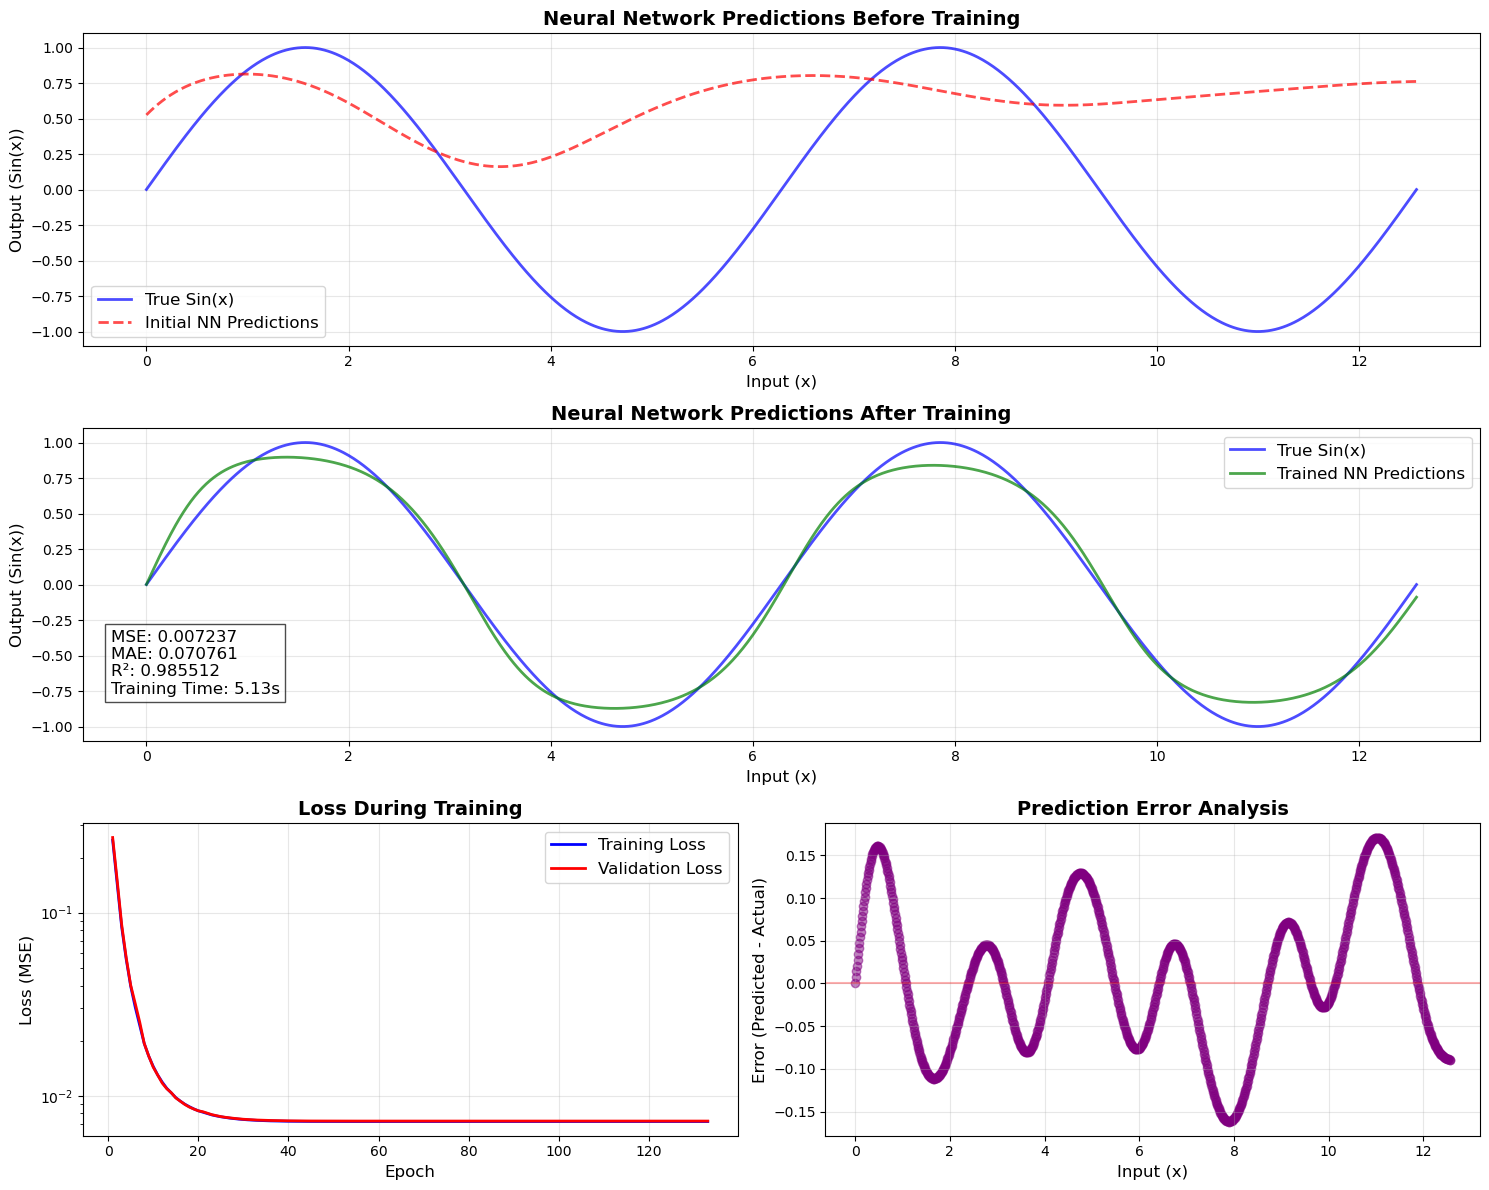

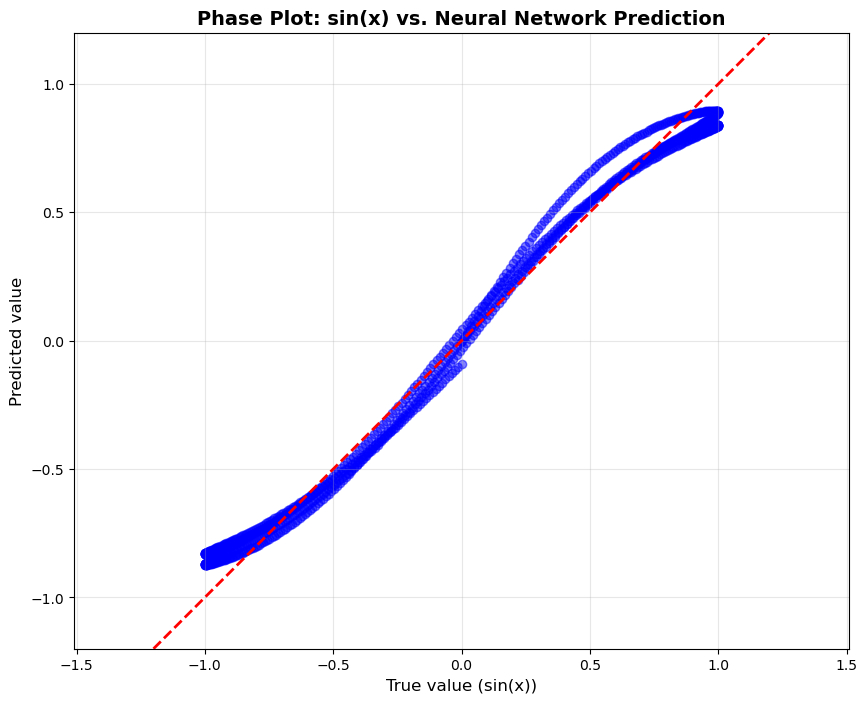

In [14]:
# Suppress tqdm warning
warnings.filterwarnings("ignore", category=UserWarning)

# Generate data with more range for better testing
x = np.linspace(0, 4 * np.pi, 1000)  # Expanded range to test generalization
y = np.sin(x)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Prepare data in the format needed by the neural network
training_data = [
    (np.array([i]).reshape(1, 1), np.array([j]).reshape(1, 1)) 
    for i, j in zip(x_train, y_train)
]
validation_data = [
    (np.array([i]).reshape(1, 1), np.array([j]).reshape(1, 1)) 
    for i, j in zip(x_val, y_val)
]

# Feature engineering: Add sin and cos of the input as features
# This helps the network learn periodic functions much faster
training_data_enhanced = [
    (np.array([[x[0][0], np.sin(x[0][0]), np.cos(x[0][0])]]).T, y) 
    for x, y in training_data
]
validation_data_enhanced = [
    (np.array([[x[0][0], np.sin(x[0][0]), np.cos(x[0][0])]]).T, y) 
    for x, y in validation_data
]

# Optimized network architecture for sine wave approximation
# standard gradient descent
nn = NeuralNetwork(
    layer_sizes=[3, 32, 16, 1],  # Smaller network with engineered features
    activations=['tanh', 'tanh', 'tanh'],  # Tanh is ideal for sine waves
    dropout_rates=[0.0, 0.0, 0],  # No dropout needed with proper features
    momentum=False
)

# Minimal L2 regularization
nn.lambd = 0.0

# Compute initial predictions for visualization
nn.toggle_training(False)
initial_predictions = []
for i in x:
    # Create the feature-engineered input
    enhanced_input = np.array([[i, np.sin(i), np.cos(i)]]).T
    initial_predictions.append(nn.feedforward(enhanced_input)[0][0])
initial_predictions = np.array(initial_predictions)

# Create figure with better layout
plt.figure(figsize=(15, 12))
gs = GridSpec(3, 2)

# Plot 1: Initial predictions
ax1 = plt.subplot(gs[0, :])
ax1.plot(x, y, 'b-', label="True Sin(x)", linewidth=2, alpha=0.7)
ax1.plot(x, initial_predictions, 'r--', label="Initial NN Predictions", linewidth=2, alpha=0.7)
ax1.set_title("Neural Network Predictions Before Training", fontsize=14, fontweight='bold')
ax1.set_xlabel("Input (x)", fontsize=12)
ax1.set_ylabel("Output (Sin(x))", fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Train the network with optimized hyperparameters
print("Training neural network...")
start_time = time.time()

history = nn.train(
    training_data=training_data_enhanced,
    epochs=200,  # Fewer epochs needed with better features
    mini_batch_size=32,  # Smaller batches for more frequent updates
    learning_rate=0.01,  # Higher learning rate is fine with proper initialization
    decay=0.005,  # Slower decay
    schedule_type="exp_decay",  # Exponential decay for smoother reduction
    validation_data=validation_data_enhanced,
    early_stopping_patience=20,  # Earlier stopping is fine
    verbose=True
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Get final predictions
nn.toggle_training(False)
trained_predictions = []
for i in x:
    # Create the feature-engineered input
    enhanced_input = np.array([[i, np.sin(i), np.cos(i)]]).T
    trained_predictions.append(nn.feedforward(enhanced_input)[0][0])
trained_predictions = np.array(trained_predictions)

# Plot 2: Final predictions
ax2 = plt.subplot(gs[1, :])
ax2.plot(x, y, 'b-', label="True Sin(x)", linewidth=2, alpha=0.7)
ax2.plot(x, trained_predictions, 'g-', label="Trained NN Predictions", linewidth=2, alpha=0.7)
ax2.set_title("Neural Network Predictions After Training", fontsize=14, fontweight='bold')
ax2.set_xlabel("Input (x)", fontsize=12)
ax2.set_ylabel("Output (Sin(x))", fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

# Compute error metrics
mse = np.mean((trained_predictions - y) ** 2)
mae = np.mean(np.abs(trained_predictions - y))
r2 = 1 - np.sum((y - trained_predictions) ** 2) / np.sum((y - np.mean(y)) ** 2)

# Add error metrics as text
metrics_text = f"MSE: {mse:.6f}\nMAE: {mae:.6f}\nR²: {r2:.6f}\nTraining Time: {training_time:.2f}s"
ax2.text(0.02, 0.15, metrics_text, transform=ax2.transAxes, 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Plot 3: Training and validation loss
ax3 = plt.subplot(gs[2, 0])
epochs = range(1, len(history['loss']) + 1)
ax3.plot(epochs, history['loss'], 'b-', label='Training Loss', linewidth=2)
ax3.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax3.set_title("Loss During Training", fontsize=14, fontweight='bold')
ax3.set_xlabel("Epoch", fontsize=12)
ax3.set_ylabel("Loss (MSE)", fontsize=12)
ax3.set_yscale('log')  # Log scale for better visualization
ax3.legend(fontsize=12)
ax3.grid(True, alpha=0.3)

# Plot 4: Error analysis
ax4 = plt.subplot(gs[2, 1])
error = trained_predictions - y
ax4.scatter(x, error, color='purple', alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax4.set_title("Prediction Error Analysis", fontsize=14, fontweight='bold')
ax4.set_xlabel("Input (x)", fontsize=12)
ax4.set_ylabel("Error (Predicted - Actual)", fontsize=12)
ax4.grid(True, alpha=0.3)

# Improve layout
plt.tight_layout()
plt.savefig('neural_network_sin_approximation.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional visualization: Phase plot to verify the learned function behaves correctly
plt.figure(figsize=(10, 8))
plt.title("Phase Plot: sin(x) vs. Neural Network Prediction", fontsize=14, fontweight='bold')
plt.scatter(y, trained_predictions, alpha=0.5, color='blue')
plt.plot([-1.2, 1.2], [-1.2, 1.2], 'r--', linewidth=2)  # Perfect prediction line
plt.xlabel("True value (sin(x))", fontsize=12)
plt.ylabel("Predicted value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.savefig('phase_plot.png', dpi=300, bbox_inches='tight')
plt.show()